<a href="https://colab.research.google.com/github/ckelaid/Covid-19-Tweet-BERT-Sentiment-Analysis/blob/main/Covid_19_Tweet_BERT_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle link: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

# Setting Up

Before we do anything, we setup our GPU environment:

Step 1: "Edit" => "Notebook settings" => "Hardware accelerator" => 'GPU"

In [1]:
# Step 2

import tensorflow as tf

# Get the GPU device name
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Some more setting up - we will perform language detection using SpaCy on our data as the last part of our cleaning process to remove any non-english tweets. So let's setup the SpaCy environment:

In [ ]:
!pip install --upgrade spacy

In [ ]:
!pip install spacy_langdetect

In [ ]:
!python -m spacy download en_core_web_sm

In [6]:
# Using SpaCy for language detection
from spacy_langdetect import LanguageDetector
import spacy
from spacy.language import Language

def get_lang_detector(nlp, name):
  return LanguageDetector()

nlp = spacy.load("en_core_web_sm") #1
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True) #2

Load in train and test data from OneDrive:

In [7]:
import base64

def OneDrive_DirectDownload(onedrive_link):
  data_bytes64 = base64.b64encode(bytes(onedrive_link, 'utf-8'))
  data_bytes64_string = data_bytes64.decode('utf-8').replace('/','_').replace('+','-').rstrip("=")
  result_url = f"https://api.onedrive.com/v1.0/shares/u!{data_bytes64_string}/root/content"

  return result_url

In [8]:
import pandas as pd

# Import train set
onedrive_link = 'https://1drv.ms/x/s!Av9ypDUIIPwkgXvcBZcktqG-1YAz?e=7ExdfB'
onedrive_direct_link = OneDrive_DirectDownload(onedrive_link)
print(f"Original OneDrive link: {onedrive_link}")
print(f"Generated Direct Download link: {onedrive_direct_link}")
train = pd.read_excel(onedrive_direct_link)

Original OneDrive link: https://1drv.ms/x/s!Av9ypDUIIPwkgXvcBZcktqG-1YAz?e=7ExdfB
Generated Direct Download link: https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3gvcyFBdjl5cERVSUlQd2tnWHZjQlpja3RxRy0xWUF6P2U9N0V4ZGZC/root/content


In [9]:
# Import test set
onedrive_link = 'https://1drv.ms/x/s!Av9ypDUIIPwkggAHupoH6F3Bxogg?e=AB3pjV'
onedrive_direct_link = OneDrive_DirectDownload(onedrive_link)
print(f"Original OneDrive link: {onedrive_link}")
print(f"Generated Direct Download link: {onedrive_direct_link}")
test = pd.read_excel(onedrive_direct_link)

Original OneDrive link: https://1drv.ms/x/s!Av9ypDUIIPwkggAHupoH6F3Bxogg?e=AB3pjV
Generated Direct Download link: https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3gvcyFBdjl5cERVSUlQd2tnZ0FIdXBvSDZGM0J4b2dnP2U9QUIzcGpW/root/content


In [10]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [11]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,2020-02-03 00:00:00,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",2020-02-03 00:00:00,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,2020-02-03 00:00:00,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,2020-02-03 00:00:00,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",2020-03-03 00:00:00,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [12]:
print(f"TRAINING SET: {train.shape}\nTESTING SET: {test.shape}")

TRAINING SET: (41157, 6)
TESTING SET: (3798, 6)


## Functions

We set some functions that we will use later on for different purposes:

### Data Cleaning

In [ ]:
!pip install emoji

In [14]:
#data processing
import re, string
import emoji
import nltk

#Clean emojis
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text)

#Clean punctuation, links, mentions and newline characters (\r & \n)
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)#links & mentions
    text = re.sub(r'[^\x00-\x7f]', r'', text)#non utf8/ascii characters
    banned_list = string.punctuation +'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#Clean # at end & middle of sentence
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))#remove last #
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
#remove # from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append()
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+", " ", text)

### Fine-Tuning & Training BERT

#### Tokenizing

In [15]:
# Tokenize all texts and store input_ids & attention_masks

## Template to call function:
#### 'texts' input is the text values of data (e.g. train_ros.clean_tweets.values) 
#### 'labels' is the class/sentiment/label values of data (e.g. train_ros.Sentiment.values)

def tokenize_BERT(texts, labels, MAX_LEN):
  input_ids = []
  attention_masks = []
  print('\nTokenizing...\n')
  # Iterating through all comments/tweets/reviews/texts in our data
  for text in texts:
    encoded = tokenizer.encode_plus(
        text, 
        add_special_tokens=True, 
        max_length=MAX_LEN, 
        padding='max_length', 
        return_attention_mask=True, 
        return_tensors='pt' # Return Pytorch tensors
        )
    
    # Get input_ids & attention_masks
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  # Convert to tensors
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  print('\nDone')

  return input_ids, attention_masks, labels

#### Train - Validation Split

In [16]:
# Function for Train - Validation split

from torch.utils.data import TensorDataset, random_split

def train_valid_split(input_ids, attention_masks, labels):

  # Make TensorDataset of training inputs
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # 90-10 train-validation split
  train_size = int(0.9*len(dataset)) # 90% training
  val_size = len(dataset) - train_size # remaining 10% validation

  # Split randomly
  train_set, val_set = random_split(dataset, [train_size, val_size])

  return train_set, val_set

#### Iterator (save up on memory)

In [17]:
# Function for iterator to help save memory
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

def set_iterator(train_set, val_set, batch_size):
  # Batch size: 16 or 32 depending on processing power available

  # Our iterators:

  # Pick training samples randomly
  train_dataloader = DataLoader(train_set, sampler=RandomSampler(train_set), batch_size=batch_size)

  # Pick validation samples sequentially (order doesn't matter)
  val_dataloader = DataLoader(val_set, sampler=SequentialSampler(val_set), batch_size=batch_size)

  return train_dataloader, val_dataloader

#### Optimizer & Learning Rate Scheduler

In [ ]:
!pip install transformers

In [20]:
# Optimizer & Learning Rate Scheduler function
from transformers import get_linear_schedule_with_warmup

def set_optimizer_lrScheduler(epochs, lrate, epsilon):
  # epochs: authors recommend 2 to 4
  # lrate: 5e-5, 3e-5, 2e-5
  # epsilon: 1e-8 (default)
  
  # Optimizer
  optimizer = AdamW(model.parameters(), lr=lrate, eps=epsilon) #Can try adjusting those for better accuracy
  
  # Total training steps [nbr of batches] * [nbr of epochs]
  total_steps = len(train_dataloader)*epochs

  # Learning rate scheduler
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = total_steps)

  return optimizer, total_steps, scheduler

#### Training Loop

In [21]:
# Helper function for calculating accuracy
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
# Helper function for formatting elapsed times as hh:mm:ss

import time
import datetime

def format_time(elapsed):
  '''
  Takes a time in seconds and returns a string hh:mm:ss
  '''
  # Round to the nearest second.
  elapsed_rounded = int(round(elapsed))

  # Format hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [23]:
# Training function

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


def training_BERT(epochs, optimizer, scheduler, train_dataloader, val_dataloader):

  # To measure the total training time for the whole run.
  total_t0 = time.time()

  # Iterate through each epoch
  for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # To measure how long the training epoch takes
    t0 = time.time()

    # Reset total loss 
    total_train_loss = 0

    # Put model into training mode
    model.train()

    # Iterate through each training batch
    for step, batch in enumerate(train_dataloader):

      # Progress update every 40 batches
      if step % 40 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)  
        # Report progress
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
      
      # Unpack batch from dataloader and copy tensors to GPU
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      # Clear gradients
      model.zero_grad()

      # Forward pass (evaluate the model on this training batch)
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask, 
                     labels=b_labels, 
                     return_dict=True)

      loss = result.loss
      logits = result.logits

      # Accumulate training loss
      total_train_loss += loss.item()

      # Backward pass to calculate gradients
      loss.backward()

      # Clip gradients' norm to 1.0 to avoid "exploding gradients" problem
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters and take a step using the computed gradient
      optimizer.step()

      # Update learning rate
      scheduler.step()

    # Average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure performance on
    # the validation set

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
      # Unpack training batch from dataloader & copy tensors to GPU
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass
      with torch.no_grad():
        # Forward pass, calculate logit predictions
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels, 
                       return_dict=True)
      
      # Get loss and logits
      loss = result.loss
      logits = result.logits
            
      # Accumulate validation loss.
      total_eval_loss += loss.item()

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Calculate the accuracy for this batch of test sentences, and
      # accumulate it over all batches
      total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    # Report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append({'epoch': epoch_i + 1, 
                           'Training Loss': avg_train_loss, 
                           'Valid. Loss': avg_val_loss, 
                           'Valid. Accur.': avg_val_accuracy, 
                           'Training Time': training_time, 
                           'Validation Time': validation_time})

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  
  return training_stats, model

#### Predictions

In [24]:
# Prediction DataLoader function

def get_pred_dataloader(batch_size, test_input_ids, test_attention_masks, test_labels):
  # batch_size = 16 or 32

  # Create Prediction DataLoader
  prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  return prediction_dataloader

In [100]:
# Function for predictions on test set

def predict_BERT(prediction_dataloader):
  print('Predicting sentiment for {:,} test tweets...'.format(len(test_input_ids)))

  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Predict
  for batch in prediction_dataloader:

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack inputs from dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling model not to compute or store gradients (save memory & speed up predicting)
    with torch.no_grad():
      # Forward pass, calculate logit predicitions
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask, 
                     return_dict=True)
  
    logits = result.logits

    # Move logits & labels to CPU
    logits = logits.detach().cpu().numpy()
    labels_ids = b_labels.to('cpu').numpy()

    # Store predicition & true labels
    predictions.append(logits)
    true_labels.append(labels_ids)

  print('\nDone')

  return predictions, true_labels

#### Evaluation

In [26]:
# Confusion matrix

from sklearn.metrics import confusion_matrix

# Confusion matrix function
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

Now that we are done setting up, we can move on to the data cleaning process.

# Data Cleaning

In [27]:
print(f"TRAINING SET: {train.shape}\nTESTING SET: {test.shape}")

TRAINING SET: (41157, 6)
TESTING SET: (3798, 6)


In [28]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


To begin , we have a few columns to drop from both sets as for this analysis we are only interested in the tweets and their sentiment.

In [29]:
drop_cols = ['UserName', 'ScreenName', 'Location', 'TweetAt']
train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

In [30]:
train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [31]:
test.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [32]:
# Check for NaNs
train.isnull().sum, test.isnull().sum #No NaNs

(<bound method DataFrame.sum of        OriginalTweet  Sentiment
 0              False      False
 1              False      False
 2              False      False
 3              False      False
 4              False      False
 ...              ...        ...
 41152          False      False
 41153          False      False
 41154          False      False
 41155          False      False
 41156          False      False
 
 [41157 rows x 2 columns]>,
 <bound method DataFrame.sum of       OriginalTweet  Sentiment
 0             False      False
 1             False      False
 2             False      False
 3             False      False
 4             False      False
 ...             ...        ...
 3793          False      False
 3794          False      False
 3795          False      False
 3796          False      False
 3797          False      False
 
 [3798 rows x 2 columns]>)

In [33]:
# Check for duplicates
train.drop_duplicates(subset='OriginalTweet', inplace=True)

In [34]:
train.info() # no duplicates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 964.6+ KB


## Calling the data cleaning functions

In [35]:
#Calling the cleaning functions on the training set
texts_new_train = []
for t in train.OriginalTweet:
    texts_new_train.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [36]:
#Calling the cleaning functions on the test set
texts_new_test = []
for t in test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [37]:
# Add the cleaned tweets to the data
train['clean_tweets'] = texts_new_train
test['clean_tweets'] = texts_new_test

#Remove the uncleaned verison of the tweets
train = train.drop('OriginalTweet', axis=1)
test = test.drop('OriginalTweet', axis=1)

In [38]:
train.head()

,Sentiment,clean_tweets
0,Neutral,and and
1,Positive,advice talk to your neighbours family to excha...
2,Positive,coronavirus australia woolworths to give elder...
3,Positive,my food stock is not the only one which is emp...
4,Extremely Negative,me ready to go at supermarket during the covid...


In [39]:
test.head()

,Sentiment,clean_tweets
0,Extremely Negative,trending new yorkers encounter empty supermark...
1,Positive,when i couldnt find hand sanitizer at fred mey...
2,Extremely Positive,find out how you can protect yourself and love...
3,Negative,panic buying hits newyork city as anxious shop...
4,Neutral,toiletpaper dunnypaper coronavirus coronavirus...


Let's check the average word length in each class:

In [46]:
def avg_word_length(df, label, ax, color):
  """ AVERAGE WORD LENGTH """
  word = df[df['Sentiment']==label]['clean_tweets'].str.split().apply(lambda x : [len(i) for i in x])
  sns.histplot(word.map(lambda x: np.mean(x)), ax=ax, color=color)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


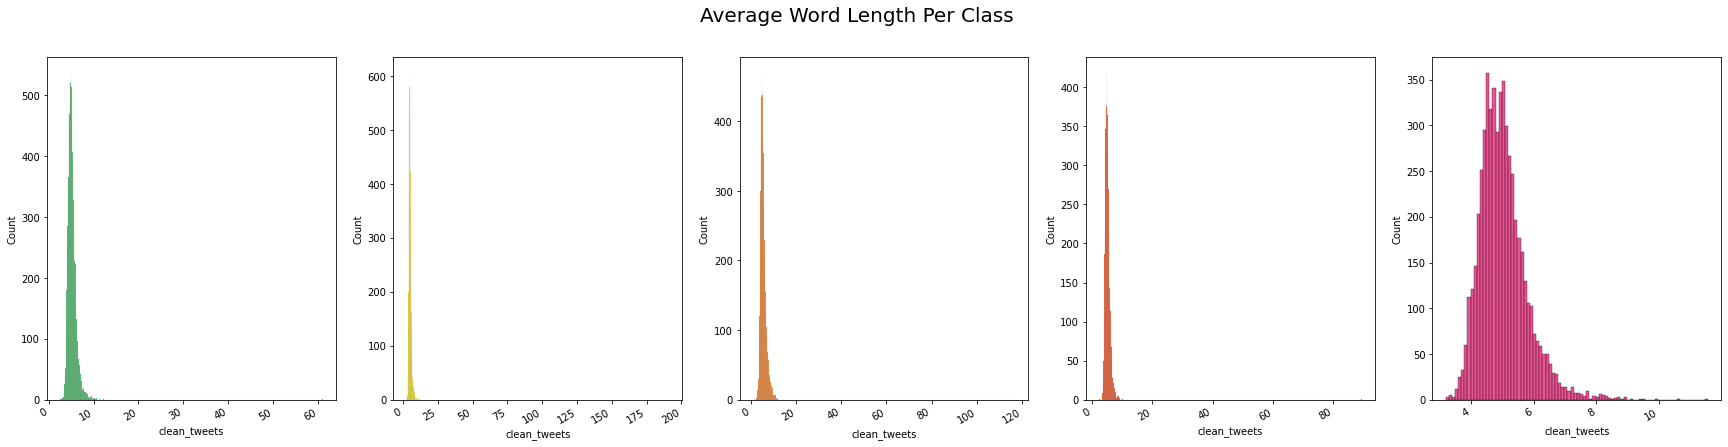

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30,7))
fig.autofmt_xdate()
fig.suptitle('Average Word Length Per Class', fontsize=20)
avg_word_length(train, "Negative", axes[0], '#39ad5a')
avg_word_length(train, "Positive", axes[1], '#e3d219')
avg_word_length(train, "Neutral", axes[2], '#e37419')
avg_word_length(train, "Extremely Positive", axes[3], '#e34519')
avg_word_length(train, "Extremely Negative", axes[4], '#e31970')
plt.show()

Considering we dropped a few tweets already after calling our data cleaning functions, let's further look at tweet length, particularly the lower lengths to see if have any tweets with 0 words or just very few words:

In [48]:
#Length of each tweet (train set)
text_len_train = []
for tweet in train.clean_tweets:
    tweet_len = len(tweet.split())
    text_len_train.append(tweet_len)

#Add it to the data frame
train["Tweet_length"] = text_len_train

In [49]:
#Length of each tweet (test set)
text_len_test = []
for tweet in test.clean_tweets:
    tweet_len = len(tweet.split())
    text_len_test.append(tweet_len)

test['Tweet_length'] = text_len_test

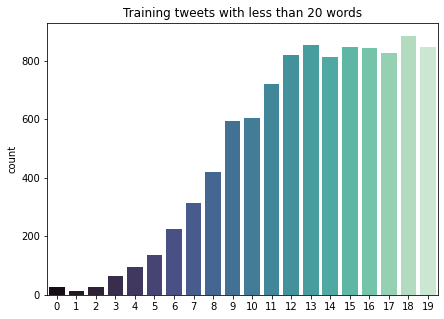

In [50]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='Tweet_length', data=train[train['Tweet_length']<20], palette='mako')
plt.title('Training tweets with less than 20 words')
plt.yticks()
plt.ylabel('count')
plt.xlabel('')
plt.show()

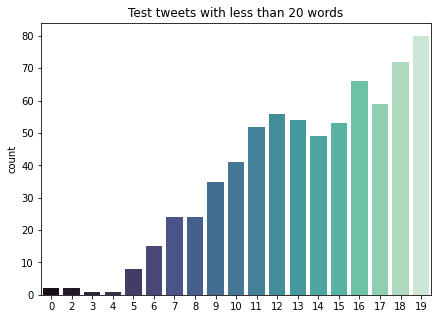

In [51]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='Tweet_length', data=test[test['Tweet_length']<20], palette='mako')
plt.title('Test tweets with less than 20 words')
plt.yticks()
plt.ylabel('count')
plt.xlabel('')
plt.show()

As we can see, there are a few tweets with 0 words; this is due to the cleaning performed prior. This means that some tweets contained only mentions, hashtags and links, which have been removed. Going forward we drop tweets of length 4 and less.

In [52]:
print(f"TRAIN SHAPE: {train.shape}")
print(f"TEST SHAPE: {test.shape}")

TRAIN SHAPE: (41157, 3)
TEST SHAPE: (3798, 3)


In [53]:
# Dropping tweets of length 4 & less
train = train[train['Tweet_length']>=4]
test = test[test['Tweet_length']>=4]

print(f"CLEAN_TRAIN SHAPE: {train.shape}")
print(f"CLEAN_TEST SHAPE: {test.shape}")

CLEAN_TRAIN SHAPE: (41029, 3)
CLEAN_TEST SHAPE: (3793, 3)


As we can see, this only removed a small amount of tweets.

In [54]:
train.head()

,Sentiment,clean_tweets,Tweet_length
1,Positive,advice talk to your neighbours family to excha...,38
2,Positive,coronavirus australia woolworths to give elder...,13
3,Positive,my food stock is not the only one which is emp...,41
4,Extremely Negative,me ready to go at supermarket during the covid...,39
5,Positive,as news of the regions first confirmed covid19...,34


In [55]:
test.head()

,Sentiment,clean_tweets,Tweet_length
0,Extremely Negative,trending new yorkers encounter empty supermark...,21
1,Positive,when i couldnt find hand sanitizer at fred mey...,29
2,Extremely Positive,find out how you can protect yourself and love...,12
3,Negative,panic buying hits newyork city as anxious shop...,35
4,Neutral,toiletpaper dunnypaper coronavirus coronavirus...,25


## Language-Detection

Before we go through with language detection, let's reorganize both sets so the indexes are in place.

In [56]:
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,Sentiment,clean_tweets,Tweet_length
0,Positive,announcing doj is going after industrial level...,20
1,Positive,for better for worse richer for poorer in sick...,12
2,Extremely Negative,if i get murdered over toilet paper im going t...,25
3,Positive,via as the covid19 outbreaks impact is spreadi...,32
4,Extremely Positive,measures by government to control spread of co...,26


In [57]:
test = test.sample(frac=1).reset_index(drop=True)
test.head()

,Sentiment,clean_tweets,Tweet_length
0,Extremely Positive,90 year old man came up to me in the grocery s...,47
1,Negative,please explain to me why you would need to sto...,37
2,Positive,great to see the older generations showing tha...,31
3,Extremely Positive,grocery store workers are also on the front li...,42
4,Positive,home shopping could double if coronavirus take...,33


In [58]:
# Now we perform language detection:

# Train set
nonEnglish_Indexes = []
for i in range(len(train.clean_tweets)):
  doc = nlp(train.clean_tweets[i])
  if doc._.language['language'] != 'en': #Checking for non-english tweets
    nonEnglish_Indexes.append(i) # Storing non-english indexes

In [59]:
len(nonEnglish_Indexes) #This varies (by a little) depending on what SpaCy distinguishes as non-english

223

In [60]:
# Test set
nonEnglish_test_Indexes = []
for i in range(len(test.clean_tweets)):
  doc = nlp(test.clean_tweets[i])
  if doc._.language['language'] != 'en': #Checking for non-english tweets
    nonEnglish_test_Indexes.append(i) # Storing non-english indexes

In [61]:
len(nonEnglish_test_Indexes) #This varies (by a little) depending on what SpaCy distinguishes as non-english

15

In [62]:
print(f"TRAIN: {train.shape}\nTEST: {test.shape}")

TRAIN: (41029, 3)
TEST: (3793, 3)


In [63]:
# Dropping non-english tweets

# Train
train = train.drop(nonEnglish_Indexes)
test = test.drop(nonEnglish_test_Indexes)

print(f"TRAIN: {train.shape}\nTEST: {test.shape}")

TRAIN: (40806, 3)
TEST: (3778, 3)


Let's reorganize our indexes one last time, and we can move on to the training and fine-tuning of BERT.

In [64]:
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [65]:
train.head()

,Sentiment,clean_tweets,Tweet_length
0,Extremely Positive,nofilter i dont care what youre offering loo r...,30
1,Positive,people always cite how much prices will increa...,44
2,Negative,shout out to for the excellent service in deal...,35
3,Extremely Negative,when youre desperate for bread during the coro...,13
4,Negative,covid19 odisha food supplies minister urges pe...,13


In [66]:
test.head()

,Sentiment,clean_tweets,Tweet_length
0,Extremely Positive,since i was just supermarket shopping i was cu...,49
1,Extremely Negative,grocery store almost entirely sold out of meat...,39
2,Extremely Negative,whos going to want to go to the grocery store ...,54
3,Positive,shoutout to the grocery store workers for endu...,36
4,Negative,americans are escaping she flew to nz to escap...,39


# Sentiment Analysis

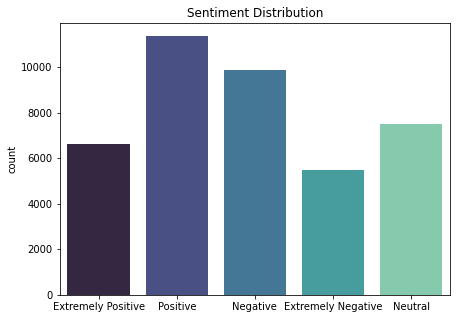

In [67]:
# Visualise Sentiment

plt.figure(figsize=(7,5))
ax = sns.countplot(x='Sentiment', data=train, palette='mako')
plt.title('Sentiment Distribution')
plt.yticks()
plt.ylabel('count')
plt.xlabel('')
plt.show()

We want to numerize our classes and limit ourselves to three classes. So something like [0 = Negative, 1 = Neutral, 2 = Positive].

In [72]:
# Train set
train['Sentiment'] = train['Sentiment'].map({'Extremely Negative': 0, 'Negative': 0, 'Neutral': 1, 'Extremely Positive': 2, 'Positive': 2})
# Test set
test['Sentiment'] = test['Sentiment'].map({'Extremely Negative': 0, 'Negative': 0, 'Neutral': 1, 'Extremely Positive': 2, 'Positive': 2})

In [73]:
train.head()

,Sentiment,clean_tweets,Tweet_length
0,2,nofilter i dont care what youre offering loo r...,30
1,2,people always cite how much prices will increa...,44
2,0,shout out to for the excellent service in deal...,35
3,0,when youre desperate for bread during the coro...,13
4,0,covid19 odisha food supplies minister urges pe...,13


In [74]:
test.head()

,Sentiment,clean_tweets,Tweet_length
0,2,since i was just supermarket shopping i was cu...,49
1,0,grocery store almost entirely sold out of meat...,39
2,0,whos going to want to go to the grocery store ...,54
3,2,shoutout to the grocery store workers for endu...,36
4,0,americans are escaping she flew to nz to escap...,39


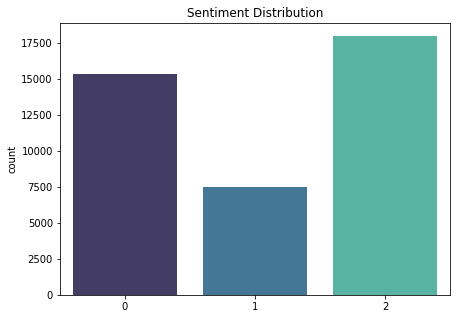

In [75]:
# Visualise Sentiment

plt.figure(figsize=(7,5))
ax = sns.countplot(x='Sentiment', data=train, palette='mako')
plt.title('Sentiment Distribution')
plt.yticks()
plt.ylabel('count')
plt.xlabel('')
plt.show()

The classes appear unbalanced, let's view their counts:

In [76]:
train['Sentiment'].value_counts() # Unbalanced.

2    17975
0    15330
1     7501
Name: Sentiment, dtype: int64

Note on the lack of balance between classes: While yes they are unbalanced, between the train set, test set and the whole set (general population), the sets are unbalanced in the same way meaning the populations mirror eachother, which is what we want.

Now, to address the unbalance and train with more accuracy on the train set we perform **Random Over Sampling** (on train set of course):

Note: Another good way (even better maybe) of dealing with unbalanced classes is to use **SMOTE**. Perhaps we can see how BERT performs when we balance our classes using **SMOTE** compared to balancing them with **ROS**, for now we balance them using **ROS**.

### ROS

In [77]:
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
import numpy as np

ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(train['clean_tweets']).reshape(-1,1),
                                   np.array(train['Sentiment']).reshape(-1,1));
train_ros = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)),
                        columns = ['clean_tweets', 'Sentiment']);

In [78]:
train_ros['Sentiment'].value_counts() # Now the classes are balanced

2    17975
1    17975
0    17975
Name: Sentiment, dtype: int64

In [79]:
train_ros.head()

,clean_tweets,Sentiment
0,nofilter i dont care what youre offering loo r...,2
1,people always cite how much prices will increa...,2
2,shout out to for the excellent service in deal...,0
3,when youre desperate for bread during the coro...,0
4,covid19 odisha food supplies minister urges pe...,0


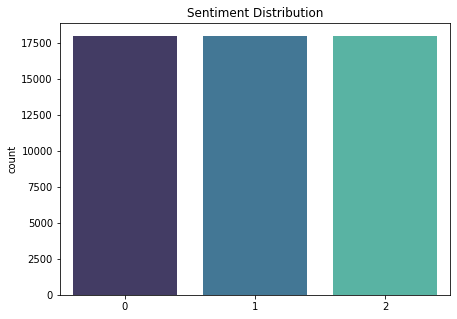

In [80]:
# Visualise Sentiment

plt.figure(figsize=(7,5))
ax = sns.countplot(x='Sentiment', data=train_ros, palette='mako')
plt.title('Sentiment Distribution')
plt.yticks()
plt.ylabel('count')
plt.xlabel('')
plt.show()

# Fine-Tuning BERT

## Tokenizing

In [ ]:
from transformers import BertTokenizer

# Import tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [82]:
Xros = train_ros['clean_tweets'].values
yros = train_ros['Sentiment'].values

X_test = test['clean_tweets'].values
y_test = test['Sentiment'].values

In [83]:
# Verify max length 

# Concatenate train & test sets to get max length of all reviews in the whole data
all_tweets = np.concatenate([Xros, X_test])

# Encode concatenated data
encoded_tweets = [tokenizer.encode(sentence, add_special_tokens=True) for sentence in all_tweets]

# Get max length
max_len = max([len(sentence) for sentence in encoded_tweets])
print('Max length: ', max_len)

Max length:  96


In [84]:
# Specify max length
MAX_LEN = 128 #Just in case we have some longer sentences

# Set values
tweets = train_ros.clean_tweets.values
labels = train_ros.Sentiment.values

# To store input_ids & attention_masks
input_ids = []
attention_masks = []

In [85]:
# Call tokenize_BERT function
input_ids, attention_masks, labels = tokenize_BERT(tweets, labels, MAX_LEN)


Tokenizing...


Done


In [86]:
# Print tweet 0 as text and as a list of token_ids
print('\nOriginal:', tweets[0])
print('\nToken IDs:', input_ids[0])


Original: nofilter i dont care what youre offering loo rolls hand sanitizer eggs champagne or big penis im just not interested youre not worth it socialdistancing coronavirus london london united kingdom

Token IDs: tensor([  101,  2053,  8873, 21928,  1045,  2123,  2102,  2729,  2054,  2115,
         2063,  5378,  8840,  2080,  9372,  2192,  2624, 25090,  6290,  6763,
        12327,  2030,  2502, 19085, 10047,  2074,  2025,  4699,  2115,  2063,
         2025,  4276,  2009,  2591, 10521,  5794,  6129, 21887, 23350,  2414,
         2414,  2142,  2983,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
   

### Train - Validation Split

In [87]:
# Calling train_valid_split
train_set, val_set = train_valid_split(input_ids, attention_masks, labels)

In [88]:
# Size of train & valid set
print('{:>5,} training samples'.format(len(train_set)))
print('{:>5,} validation samples'.format(len(val_set)))

48,532 training samples
5,393 validation samples


In [89]:
# calling set_iterator
train_dataloader, val_dataloader = set_iterator(train_set, val_set, 16) # batch_size = 16

### Optimizer & Learning rate Scheduler

In [90]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top

# num_labels = 3 b/c we have 3 classes
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3, output_attentions=False, output_hidden_states=False)

# Tell Pytorch to run model on GPU
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [91]:
# Calling set_optimizer_lrScheduler with: epochs = 2, learning_rate = 2e-5, epsilon = 1e-8
optimizer, total_steps, scheduler = set_optimizer_lrScheduler(2, 2e-5, 1e-8)

### Training Loop

In [92]:
import random
import numpy as np

# Specify seed value for reproducibility
seed_val = 42 # or smth else
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# To store our training statistics (loss, accuracy, etc.)
training_stats = []

In [93]:
# Calling training_BERT
training_stats, model = training_BERT(2, optimizer, scheduler, train_dataloader, val_dataloader)


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  3,034.    Elapsed: 0:00:14.
  Batch    80  of  3,034.    Elapsed: 0:00:28.
  Batch   120  of  3,034.    Elapsed: 0:00:42.
  Batch   160  of  3,034.    Elapsed: 0:00:57.
  Batch   200  of  3,034.    Elapsed: 0:01:11.
  Batch   240  of  3,034.    Elapsed: 0:01:26.
  Batch   280  of  3,034.    Elapsed: 0:01:40.
  Batch   320  of  3,034.    Elapsed: 0:01:54.
  Batch   360  of  3,034.    Elapsed: 0:02:08.
  Batch   400  of  3,034.    Elapsed: 0:02:23.
  Batch   440  of  3,034.    Elapsed: 0:02:37.
  Batch   480  of  3,034.    Elapsed: 0:02:51.
  Batch   520  of  3,034.    Elapsed: 0:03:06.
  Batch   560  of  3,034.    Elapsed: 0:03:20.
  Batch   600  of  3,034.    Elapsed: 0:03:34.
  Batch   640  of  3,034.    Elapsed: 0:03:48.
  Batch   680  of  3,034.    Elapsed: 0:04:03.
  Batch   720  of  3,034.    Elapsed: 0:04:17.
  Batch   760  of  3,034.    Elapsed: 0:04:31.
  Batch   800  of  3,034.    Elapsed: 0:04:46.
  Batch   840  of

Let's look at the training summary:

In [95]:
import pandas as pd

# Display floats with two decimals
pd.set_option('precision', 2)

# Create DataFrame from our training stats
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('epoch')

# Display table
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.46,0.30,0.90,0:18:05,0:00:41
2,0.23,0.26,0.92,0:18:05,0:00:41


**Note:** As training loss decreases, so does validation loss. This means that two epochs was a good pick. If as training loss decreased, validation loss increased it would suggest we are training our model too long (too many epochs) and overfitting data.

**Note:** Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, only which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

We can vizualise our training & validation loss.

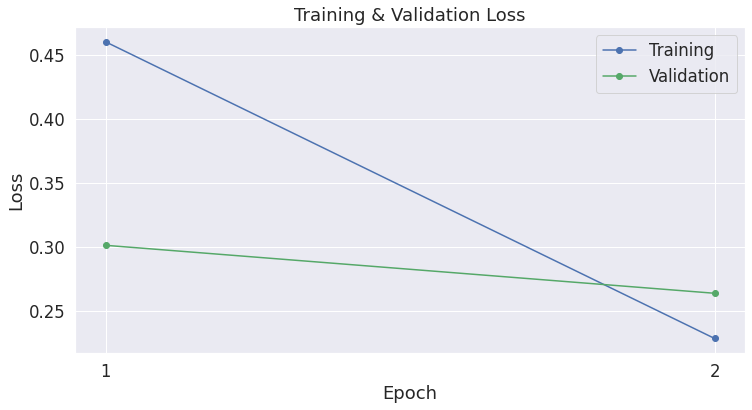

In [96]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2,]) 

plt.show()

### Evaluation

So as per the above results, our model has a 0.92 accuracy on the validation set. Now let's evaluate it on the test set.

Before we can evaluate our model on the test set, we need to tokenize the test set and prepare it for evaluation.

In [101]:
# Tokenizing the test set
print('Number of test tweets: {:,}\n'.format(test.shape[0]))

# Set values
tweets = test.clean_tweets.values
labels = test.Sentiment.values

# Calling the tokenizing function
test_input_ids, test_attention_masks, test_labels = tokenize_BERT(tweets, labels, MAX_LEN)

Number of test tweets: 3,778


Tokenizing...


Done


In [102]:
# Calling get_pred_dataloader with batch_size = 16
prediction_dataloader = get_pred_dataloader(16, test_input_ids, test_attention_masks, test_labels)

We can now make our predictions.

#### Predictions on test set



In [103]:
# Calling predict_BERT
predictions, true_labels = predict_BERT(prediction_dataloader)

Predicting sentiment for 3,778 test tweets...

Done


In [104]:
len(predictions) # Length of individual batches (combine all batches and get full test set predicitons => np.concatenate(predictions, axis=0))

237

In [105]:
len(true_labels) #Check (individual batch length)

237

Now to check how our model did in predicting sentiment on the test set, we need to combine our predicitons & true labels accross all batches, because currently these latter hold values for individual batches.

In [106]:
# Combine the results across all batches
flat_predictions = np.concatenate(predictions, axis=0)

# Combine the correct labels for each batch into a single list
flat_true_labels = np.concatenate(true_labels, axis=0)

# For our predictions, for each sample, pick the sentiment (0, 1, or 2) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [107]:
# Check now that we combined
len(flat_true_labels), len(flat_predictions) # Yep, we get the length of test set tweets & labels 

(3778, 3778)

Let's first compute a confusion matrix:

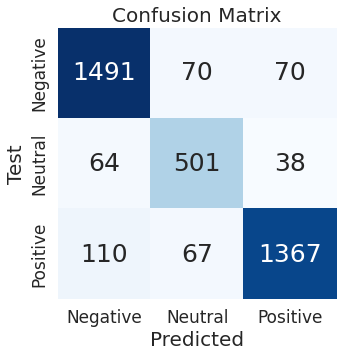

In [108]:
# Calling conf_matrix
conf_matrix(flat_true_labels, flat_predictions, 'Confusion Matrix')

We can see the way our BERT model classified the tweets, it seems to have done a pretty good job!

Now let's see if we can attribute some type of score to this. 

We compute the recall, precision, F1 score, Matthew Correlation Coefficient (MCC) and Accuracy (proportion of correct predictions):

In [126]:
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef

# Precision
precision = precision_score(y_true=flat_true_labels, y_pred=flat_predictions, average='weighted')

# Recall
recall = recall_score(y_true=flat_true_labels, y_pred=flat_predictions, average='weighted')

# F1 score
f1 = f1_score(y_true=flat_true_labels, y_pred=flat_predictions, average='weighted')

# MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

# Accuracy
accuracy = sum(flat_predictions == flat_true_labels) / len(flat_true_labels)

# Store evaluation metrics
evaluation_metrics = ({'Precision': precision, 
                       'Recall': recall,
                       'F1': f1,
                       'MCC': mcc,
                       'Accuracy': accuracy})


# Make dataframe of evaluation metrics

# Display floats with three decimals
pd.set_option('precision', 3)

# Create DataFrame 
df_evaluation_metrics = pd.DataFrame(data=evaluation_metrics, index=['score'])

# Display
df_evaluation_metrics

,Precision,Recall,F1,MCC,Accuracy
score,0.891,0.889,0.89,0.822,0.889


Overall we see our model predicted sentiment pretty accurately with an Accuracy of 88.9%. However, as we mentioned earlier accuracy can sometimes be misleading and not capture the true weight of false positives and false negatives, which is why we computed the recall, precision and F1 score.

Precision is the proportion of true positives amidst true positives and the false positives, while recall is the proportion of true positives amidst true positives and false negatives. The F1-score takes precision and recall into account to present an accuracy that puts weight on false positives and false negatives. Hence, with an F1-score of 0.89 we can support our computed accuracy of 88.9% and say that we indeed have a pretty accurate model.

Finally, as a last confirmation that our model predicts sentiment accurately, we have an MCC of 0.82. To understand how the MCC works, the MCC is between -1 & 1, with 1 being a perfect prediction, 0 an average random prediction and -1 being an inverse prediction. So yeah, an MCC of 0.82 is quite good!

# Conclusion

So in this project we saw how we can fine-tune and train a BERT model for classification, precisely for sentiment classification or sentiment analysis.


After some data cleaning and transformation, our final model outputed an F1-score of 0.89 and an MCC of 0.82 indicating our model predicted sentiment quite accurately.

We can try and increase this accuracy by adding an epoch or two, however too much can make us overfit the data, additionally we can play with the *learning rate* and *epsilon* value of our optimizer.

Lastly, to increase our model's performance, we should retrain it, but this time on the full training set (training set + validation set).